In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 28 11:55:57 2022

@author: evelynm
---
Parallel calculation per hazard via impact cascade to saving results.

"""

import os
import sys
import geopandas as gpd
from copy import copy, deepcopy
import numpy as np
import pandas as pd
import pickle
import shapely

from climada.entity.exposures.base import Exposures
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet
from climada.engine import Impact
from climada.hazard.base import Hazard, Centroids
from climada.hazard import TCTracks, TropCyclone
from climada.util import lines_polys_handler as u_lp
from climada.util import coordinates as u_coord

from climada_petals.engine.networks.nw_base import Network
from climada_petals.engine.networks.nw_calcs import Graph
import climada_petals.engine.networks.nw_utils as nwu


# =============================================================================
# Impact Class Defs
# =============================================================================

class ImpFuncsCIFlood():
    
    def __init__(self):
        self.tag = 'FL'
        self.road = self.step_impf()
        self.health = self.step_impf()
        self.education = self.step_impf()
        self.power_line_e = self.no_impf() # for edges!
        self.power_line_n = self.step_impf() # for nodes! (aka substations)
        self.power_tower = self.no_impf()
        self.power_plant = self.no_impf()
        self.water_plant = self.no_impf()
        self.celltower = self.step_impf()
        self.people = self.step_impf()
        
    def step_impf(self):
        step_impf = ImpactFunc() 
        step_impf.id = 1
        step_impf.haz_type = 'FL'
        step_impf.name = 'Step function flood'
        step_impf.intensity_unit = ''
        step_impf.intensity = np.array([0, 0.95,0.955, 1])
        step_impf.mdd =       np.array([0, 0, 1, 1])
        step_impf.paa =       np.sort(np.linspace(1, 1, num=4))
        step_impf.check()
        return step_impf
    
    def no_impf(self):
        no_impf = ImpactFunc() 
        no_impf.id = 2
        no_impf.haz_type = 'FL'
        no_impf.name = 'No impact function flood'
        no_impf.intensity_unit = ''
        no_impf.intensity = np.array([0, 1])
        no_impf.mdd =       np.array([0, 0])
        no_impf.paa =       np.sort(np.linspace(1, 1, num=2))
        no_impf.check()
        return no_impf


class ImpFuncsCIWind():
    
    def __init__(self):
        self.tag = 'TC'
        self.road = self.road_impf() # for edges!
        self.education = self.resid_impf()
        self.health = self.health_level_1_4_impf()
        self.power_line_e = self.pl_impf() # for edges!
        self.power_line_n = self.no_impf() # for nodes!
        self.power_tower = self.pt_impf()
        self.power_plant = self.no_impf()
        self.water_plant = self.no_impf()
        self.celltower = self.tele_impf()
        self.people = self.people_impf()
        
    def road_impf(self):
        # Road adapted from Koks et al. 2019 (tree blowdown on road > 42 m/s)
        # anecdotal case-study Mühlhofer et al. 2022 (over-estimate) that for 42 m/s all roads sustain 100% damage
        # --> sigmoid function with v 1/2 at 42 m/s and max dmg at 50%
        v_eval = np.linspace(0, 120, num=120)
        L=50
        k=0.3
        x0=42
        mdd = []
        for v in v_eval:
            mdd.append(L/(1 + np.exp(-k * (v-x0)))/100)
        impf_road = ImpactFunc() 
        impf_road.id = 2
        impf_road.haz_type = 'TC'
        impf_road.name = 'Road dmg function for tree blowdown from strong winds'
        impf_road.intensity_unit = 'm/s'
        impf_road.intensity = np.array(v_eval)
        impf_road.mdd = np.array(mdd)
        impf_road.paa = np.sort(np.linspace(1, 1, num=120))
        impf_road.check()
        return impf_road
    
    def resid_impf(self):
        # adapted from figure H.13 (residential 2-story building) loss function, Hazus TC 2.1 (p.940)
        # medium terrain roughness parameter (z_theta = 0.35)
        impf_educ = ImpactFunc() 
        impf_educ.id = 5
        impf_educ.tag = 'TC educ'
        impf_educ.haz_type = 'TC'
        impf_educ.name = 'Loss func. residental building z0 = 0.35'
        impf_educ.intensity_unit = 'm/s'
        impf_educ.intensity = np.array([0, 30, 60, 80, 100, 120, 140, 160, 180, 200, 260]) / 2.237
        impf_educ.mdd =       np.array([0, 0,  5,  20,  50,  80,  98,  98,  98, 100, 100]) / 100
        impf_educ.paa = np.sort(np.linspace(1, 1, num=11))
        impf_educ.check()
        return impf_educ

    def health_level_1_4_impf(self):
        impf_health_1_4 = ImpactFunc()
        impf_health_1_4.id = 9
        impf_health_1_4.haz_type = 'TC'
        impf_health_1_4.name = 'Step function health'
        impf_health_1_4.intensity_unit = 'm/s'
        impf_health_1_4.intensity = np.array([12, 18, 20, 40, 50, 60, 70, 90])
        impf_health_1_4.mdd = np.array([0, 0.03, 0.3, 0.5, 0.6, 0.61, 0.61, 0.61])
        impf_health_1_4.paa = np.ones(impf_health_1_4.intensity.shape)
        impf_health_1_4.check()
        return impf_health_1_4

    def health_level_1_4_impf_adapt(self):
        impf_health_1_4 = ImpactFunc()
        impf_health_1_4.id = 10
        impf_health_1_4.haz_type = 'TC'
        impf_health_1_4.name = 'Step function health adapted'
        impf_health_1_4.intensity_unit = 'm/s'
        impf_health_1_4.intensity = np.array([21, 26, 29, 48, 60, 65, 70, 90])
        impf_health_1_4.mdd = np.array([0, 0.03, 0.28, 0.45, 0.54, 0.55, 0.55, 0.55])
        impf_health_1_4.paa = np.ones(impf_health_1_4.intensity.shape)
        impf_health_1_4.check()
        return impf_health_1_4

    def indus_impf(self):
        # adapted from figure N.1 (industrial 2 building) loss function, Hazus TC 2.1 (p.1115)
        # medium terrain roughness parameter (z_theta = 0.35)
        impf_indus = ImpactFunc() 
        impf_indus.id = 4
        impf_indus.haz_type = 'TC'
        impf_indus.name = 'Loss func. industrial building z0 = 0.35'
        impf_indus.intensity_unit = 'm/s'
        impf_indus.intensity = np.array([0, 30, 60, 80, 100, 120, 140, 160, 180, 200, 260]) / 2.237 
        impf_indus.mdd =       np.array([0, 0,   0,   5,  15,  70,  98, 100, 100, 100, 100]) / 100
        impf_indus.paa = np.sort(np.linspace(1, 1, num=11))
        impf_indus.check()
        return impf_indus
        
    def no_impf(self):
        impf_none = ImpactFunc() 
        impf_none.id = 6
        impf_none.haz_type = 'TC'
        impf_none.name = 'No-impact func'
        impf_none.intensity_unit = 'm/s'
        impf_none.intensity = np.array([0,  140])  
        impf_none.mdd =       np.array([0, 0 ])         
        impf_none.paa = np.sort(np.linspace(1, 1, num=2))
        impf_none.check()
        return impf_none

    def tele_impf(self):
        # adapted from newspaper articles ("cell towers to withstand up to 110 mph")
        impf_tele = ImpactFunc() 
        impf_tele.id = 3
        impf_tele.haz_type = 'TC'
        impf_tele.name = 'Loss func. cell tower'
        impf_tele.intensity_unit = 'm/s'
        impf_tele.intensity = np.array([0, 80, 100, 260]) / 2.237 #np.linspace(0, 120, num=13)
        impf_tele.mdd =       np.array([0,  0, 100,  100]) / 100
        impf_tele.paa = np.sort(np.linspace(1, 1, num=4))
        impf_tele.check()
        return impf_tele
   
    def p_fail_pl(self, v_eval, v_crit=30, v_coll=60):
        """
        adapted from  https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7801854
         Vulnerability Assessment for Power Transmission Lines under Typhoon 
        Weather Based on a Cascading Failure State Transition Diagram
        """
        p_fail = []
        for v in v_eval:
            p = 0
            if (v > v_crit) & (v < v_coll):
                p = np.exp(0.6931*(v-v_crit)/v_crit)-1
            elif v > v_coll:
                p = 1
            p_fail.append(p)
        return p_fail
    
    def pl_impf(self, v_crit=30, v_coll=60):
        # Power line
        v_eval = np.linspace(0, 120, num=120)
        p_fail_powerlines = self.p_fail_pl(v_eval, v_crit=v_crit, v_coll=v_coll)
        impf_prob = ImpactFunc() 
        impf_prob.id = 1
        impf_prob.tag = 'PL_Prob'
        impf_prob.haz_type = 'TC'
        impf_prob.name = 'power line failure prob'
        impf_prob.intensity_unit = 'm/s'
        impf_prob.intensity = np.array(v_eval)
        impf_prob.mdd = np.array(p_fail_powerlines)
        impf_prob.paa = np.sort(np.linspace(1, 1, num=120))
        impf_prob.check()
        return impf_prob
    
    def pl_impf_adapt(self, v_crit=35, v_coll=70):
        # Power line
        v_eval = np.linspace(0, 120, num=120)
        p_fail_powerlines = self.p_fail_pl(v_eval, v_crit=v_crit, v_coll=v_coll)
        impf_prob = ImpactFunc() 
        impf_prob.id = 11
        impf_prob.tag = 'PL_Prob'
        impf_prob.haz_type = 'TC'
        impf_prob.name = 'power line failure prob, adapted'
        impf_prob.intensity_unit = 'm/s'
        impf_prob.intensity = np.array(v_eval)
        impf_prob.mdd = np.array(p_fail_powerlines)
        impf_prob.paa = np.sort(np.linspace(1, 1, num=120))
        impf_prob.check()
        return impf_prob
    
    def p_fail_powertower(self, v_eval, L=97.2, x0=77.8, k=0.3):
        """
        L=95, x0=80, k=0.1:
        adapted from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7801854&tag=1,
        based on 'base' class tower
        
        L=97.2, x0=77.8, k=0.3: adapted from https://arxiv.org/abs/2107.06072 Fragility curves for 
        power transmission towers in Odisha, India, 
        based on observed damage during 2019 Cyclone Fani; based on functionality disruption curve
        """
        p_fail = []
        for v in v_eval:
            p_fail.append(L/(1 + np.exp(-k * (v-x0)))/100)        
        return p_fail
    
    def pt_impf(self, L=95, x0=80, k=0.1):
        # Power tower impact function 
        v_eval = np.linspace(0, 140, num=140)
        p_fail_powertower = self.p_fail_powertower(v_eval, L=L, x0=x0, k=k) 
        impf_pt = ImpactFunc() 
        impf_pt.id = 8
        impf_pt.haz_type = 'TC'
        impf_pt.name = 'Disruption func. for power towers from strong winds'
        impf_pt.intensity_unit = 'm/s'
        impf_pt.intensity = np.array(v_eval)
        impf_pt.mdd = np.array(p_fail_powertower)
        impf_pt.paa = np.sort(np.linspace(1, 1, num=140))
        impf_pt.check()
        return impf_pt
    
    def pt_impf_adapt(self, L=105, x0=85, k=0.1):
        # Power tower impact function 
        v_eval = np.linspace(0, 140, num=140)
        p_fail_powertower = self.p_fail_powertower(v_eval, L=L, x0=x0, k=k) 
        impf_pt = ImpactFunc() 
        impf_pt.id = 12
        impf_pt.haz_type = 'TC'
        impf_pt.name = 'Disruption func. for power towers from strong winds, adapted'
        impf_pt.intensity_unit = 'm/s'
        impf_pt.intensity = np.array(v_eval)
        impf_pt.mdd = np.array(p_fail_powertower)
        impf_pt.paa = np.sort(np.linspace(1, 1, num=140))
        impf_pt.check()
        return impf_pt
 
    def people_impf(self):
        # Mapping of wind field >= hurricane scale 1 (33 m/s)
        impf_ppl = ImpactFunc() 
        impf_ppl.id = 7
        impf_ppl.haz_type = 'TC'
        impf_ppl.name = 'People - Windfield Mapping >= TC'
        impf_ppl.intensity_unit = 'm/s'
        impf_ppl.intensity = np.array([0, 32, 33, 80, 100, 120, 140, 160]) 
        impf_ppl.mdd = np.array([0, 0,   100,  100,   100,  100,  100,  100]) / 100
        impf_ppl.paa = np.sort(np.linspace(1, 1, num=8))
        impf_ppl.check()
        return impf_ppl
    
class ImpactThresh():
    def __init__(self):
        self.road = 500
        self.power_line_e = 500
        self.power_line_n = 0.4
        self.power_tower = 500
        self.celltower = 0.4
        self.power_plant = 0.4
        self.water_plant = 0.4
        self.health = 0.4
        self.education = 0.4
        self.people = np.inf

def ImpfClassDict():
    return {
        'FL' : ImpFuncsCIFlood(),
        'TC' : ImpFuncsCIWind(),
    }

# =============================================================================
# Hazard loading funcs
# =============================================================================

def load_wind_idai(cntry_shape, storm_id='2019063S18038'):
    "re-compute to 10 mins sustained winds for coherence with impact functions"
    tr_idai = TCTracks.from_ibtracs_netcdf(storm_id=storm_id)
    tr_idai.data[0]['max_sustained_wind']*= 0.88
    tr_idai.equal_timestep()
    min_lat, max_lat, min_lon, max_lon = cntry_shape.bounds[1], cntry_shape.bounds[3], cntry_shape.bounds[0], cntry_shape.bounds[2]
    cent_moz = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.12)
    cent_moz.check()
    tc_idai = TropCyclone.from_tracks(tr_idai, centroids=cent_moz)
    tc_idai.check()
    return tc_idai

def load_flood_idai(path_fl_file):
    fl_idai = Hazard.from_raster([path_fl_file], dst_crs='epsg:4326', haz_type='FL') 
    fl_idai.centroids.set_meta_to_lat_lon() #Hazard('FL').from_raster(path_fl_file)
    fl_idai.event_name = ['Flood_Idai']
    return fl_idai       
        
# =============================================================================
# Impact & cascade calc funcs
# =============================================================================

def gdf_from_network(df_edges_or_nodes, ci_type):
    return df_edges_or_nodes[df_edges_or_nodes['ci_type']==ci_type]

def exposure_from_nodes(gdf, tag=None, value=1):
    exp_pnt = Exposures(gdf)
    exp_pnt.tag = tag if tag is not None else gdf.ci_type.iloc[0]
    exp_pnt.gdf['value'] = value
    exp_pnt.set_lat_lon()
    exp_pnt.check()
    return exp_pnt
      
def exposure_from_edges(gdf, res, tag=None, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=1):
    exp_line = Exposures(gdf)
    if not disagg_val:
        disagg_val = res
    exp_pnt = u_lp.exp_geom_to_pnt(exp_line, res=res, to_meters=True, 
                                   disagg_met=disagg_met, disagg_val=disagg_val)
    exp_pnt.tag = tag if tag is not None else gdf.ci_type.iloc[0]
    exp_pnt.set_lat_lon()
    exp_pnt.check() 
    return exp_pnt

def make_impfset(imp_class):
    impfset = ImpactFuncSet()
    for attribute in set(imp_class.__dict__.keys()).difference({'tag'}):
        impfset.append(getattr(imp_class, attribute))
    return impfset

def assign_impfs(exp, haz_type, impfclass_dict=ImpfClassDict()):
    exp.gdf[f'impf_{haz_type}'] = getattr(impfclass_dict[haz_type], exp.tag).id
    
def calc_point_impacts(haz, exp, impf_set):
    imp = Impact()
    imp.calc(exp, impf_set, haz, save_mat=True)
    return imp

def binary_impact_from_prob(imp, seed=47):
    """
    where impact funcs were given as failure probability on y-axis: sample failure states
    e.g. for wind damage to power lines, and wind damage to power towers
    """
    np.random.seed = seed
    rand = np.random.random(imp.imp_mat.data.size)
    imp.imp_mat.data = np.array([1 if p_fail > rnd else 0 for p_fail, rnd in 
                                 zip(imp.imp_mat.data, rand)])
    return imp

def binary_to_origres(imp, orig_res):
    """
    where failure states were sampled, assign real underlying damage value
    """
    imp.imp_mat.data = imp.imp_mat.data*orig_res
    return imp

def impacts_to_network(imp, exp_tag, ci_network_disr):          
    func_states = list(
            map(int, imp.imp_mat.toarray().flatten()<=getattr(ImpactThresh(), exp_tag)))
    
    if exp_tag == 'road':
        ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='road',
                                  'func_internal'] = func_states
        ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='road',
                                  'imp_dir'] = imp.imp_mat.toarray().flatten()
    elif exp_tag in ['power_line_e', 'power_tower']:
        # power line edges and power towers are two impacts that are summed on the same exposure
        ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='power_line',
                                  'func_internal'] = [np.min(
            [func_state, func_internal]) for func_state, func_internal in zip(
            func_states, ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='power_line', 'func_internal'])]
        ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='power_line', 'imp_dir'] += imp.imp_mat.toarray().flatten()
        # power lines in one direction need to be impacted also in reverse direction

    elif exp_tag=='power_line_n':
        ci_network_disr.nodes.loc[
                ci_network_disr.nodes.ci_type=='power_line', 'func_internal'] = func_states
        ci_network_disr.nodes.loc[
                ci_network_disr.nodes.ci_type=='power_line', 'imp_dir'] = imp.imp_mat.toarray().flatten()
        
    else:
        ci_network_disr.nodes.loc[
                ci_network_disr.nodes.ci_type==exp_tag, 'func_internal'] = func_states
        ci_network_disr.nodes.loc[
                ci_network_disr.nodes.ci_type==exp_tag, 'imp_dir'] = imp.imp_mat.toarray().flatten()
        
    ci_network_disr.edges['func_tot'] = [np.min([func_internal, func_tot]) for 
                                          func_internal, func_tot in zip(
                                              ci_network_disr.edges.func_internal, 
                                              ci_network_disr.edges.func_tot)]
    ci_network_disr.nodes['func_tot'] = [np.min([func_internal, func_tot]) for 
                                         func_internal, func_tot in zip(
                                             ci_network_disr.nodes.func_internal, 
                                             ci_network_disr.nodes.func_tot)]
        
    return ci_network_disr

def comb_imps_to_network(ci_network, df_res):
    """
    analogous function to impact_to_network, but for combined result datafrane
    from multihazard combined impacts
    """
    ci_network_disr = deepcopy(ci_network)
    # manually assign to network - roads
    ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='road',
                                  'func_internal'] = [np.min(
        [func_state, func_internal]) for func_state, func_internal in zip(
        df_res.loc[df_res.ci_type=='road','func_internal'], 
        ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='road', 'func_internal'])]
    ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='road',
                              'imp_dir'] = df_res.loc[df_res.ci_type=='road','imp_dir'].values
    # manually assign to network - power lines edges
    ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='power_line',
                                  'func_internal'] = [np.min(
        [func_state, func_internal]) for func_state, func_internal in zip(
        df_res.loc[(df_res.ci_type=='power_line')&(df_res.geometry.type=='LineString'),'func_internal'], 
        ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='power_line', 'func_internal'])]
    ci_network_disr.edges.loc[ci_network_disr.edges.ci_type=='power_line',
                                  'imp_dir'] = df_res.loc[(df_res.
                                                           ci_type=='power_line')&
                                                          (df_res.geometry.type=='LineString'),'imp_dir']
    # manually assign to network - power lines nodes
    ci_network_disr.nodes.loc[ci_network_disr.nodes.ci_type=='power_line',
                                  'func_internal'] = [np.min(
        [func_state, func_internal]) for func_state, func_internal in zip(
        df_res.loc[(df_res.ci_type=='power_line')&(df_res.geometry.type=='Point'),'func_internal'], 
        ci_network_disr.nodes.loc[ci_network_disr.nodes.ci_type=='power_line', 'func_internal'])]
    ci_network_disr.nodes.loc[ci_network_disr.nodes.ci_type=='power_line',
                                  'imp_dir'] = df_res.loc[(df_res.
                                                           ci_type=='power_line')&
                                                          (df_res.geometry.type=='Point'),'imp_dir']
    # manually assign to network - cell towers, power plants, schools, hospitals
    for ci_type in ['celltower', 'power_plant', 'health', 'education']:
        ci_network_disr.nodes.loc[
            ci_network_disr.nodes.ci_type==ci_type,'func_internal'] = [np.min(
            [func_state, func_internal]) for func_state, func_internal in zip(
            df_res.loc[df_res.ci_type==ci_type,'func_internal'], 
            ci_network_disr.nodes.loc[ci_network_disr.nodes.ci_type==ci_type, 'func_internal'])]
        ci_network_disr.nodes.loc[
            ci_network_disr.nodes.ci_type==ci_type,
            'imp_dir'] = df_res.loc[df_res.ci_type==ci_type,'imp_dir']
    
    ci_network_disr.edges['func_tot'] = [np.min([func_internal, func_tot]) for 
                                          func_internal, func_tot in zip(
                                              ci_network_disr.edges.func_internal, 
                                              ci_network_disr.edges.func_tot)]
    ci_network_disr.nodes['func_tot'] = [np.min([func_internal, func_tot]) for 
                                         func_internal, func_tot in zip(
                                             ci_network_disr.nodes.func_internal, 
                                             ci_network_disr.nodes.func_tot)]
    return ci_network_disr

def load_friction_surf(PATH_FRICTION, cntry_shape):
    friction_surf = Hazard('FRIC').from_raster(
    PATH_FRICTION, geometry=[cntry_shape.convex_hull.buffer(0.1)])
    return friction_surf

# save selected results as feather gdf
def save_resultdf(ci_graph_disr, path_save, event_name):
    ci_network_disr = ci_graph_disr.return_network()
    vars_to_keep_edges = ['ci_type', 'func_internal', 'func_tot', 'imp_dir','geometry']
    vars_to_keep_nodes = vars_to_keep_edges.copy() 
    vars_to_keep_nodes.extend([colname for colname in ci_network_disr.nodes.columns  if 'actual_supply_' in colname])
    vars_to_keep_nodes.extend(['counts'])
        
    df_res = ci_network_disr.nodes[ci_network_disr.nodes.ci_type=='people'][vars_to_keep_nodes]
    for ci_type in ['health', 'education', 'celltower', 'power_plant', 'power_line']:
        df_res = df_res.append(ci_network_disr.nodes[ci_network_disr.nodes.ci_type==ci_type]
                                   [vars_to_keep_nodes])
    for ci_type in ['power_line', 'road']:
        df_res = df_res.append(ci_network_disr.edges[ci_network_disr.edges.ci_type==ci_type]
                                   [vars_to_keep_edges])
    df_res.to_feather(path_save+f'cascade_results_{event_name}')


def wrapper_impacts_cascades_saving(haz, ci_network, exp_list, df_dependencies, friction_surf):
    """
    Parameters
    ----------
    haz: Hazard
    ci_network : Network
    exp_list : [exp_health, exp_educ, exp_celltowers, exp_pplant, exp_pline_n, exp_pline_e, exp_ptower, exp_road]
    df_dependencies : pd.DataFrame
    friction_surf : Hazard
    
    Returns
    -------
    imp_dict : Dict
        Basic service impacts compared to baseline
    """
    if not os.path.isfile(path_save+f'cascade_results_{haz.event_name[0]}'):
        print(haz.event_name)
        # IMPACT CALCS
        ci_network_disr = deepcopy(ci_network)
        for exp in exp_list:
            imp = calc_point_impacts(haz, exp, impf_set)
            if (haz_type in ['TC', 'EQ']) & (exp.tag in ['power_line_e', 'power_tower']):
                imp = binary_impact_from_prob(imp, seed=47)
                imp = binary_to_origres(imp, res_orig)
            if exp.tag in ['road', 'power_line_e', 'power_tower']:
                imp = u_lp.impact_pnt_agg(imp, exp.gdf, u_lp.AggMethod.SUM)
            ci_network_disr = impacts_to_network(imp, exp.tag, ci_network_disr)

        # IMPACT CASCADES
        ci_graph_disr = Graph(ci_network_disr, directed=True)
        ci_graph_disr.cascade(df_dependencies, p_source='power_plant', p_sink='power_line', 
                              source_var='el_generation', demand_var='el_consumption',
                              preselect=False, initial=False, friction_surf=friction_surf, 
                              dur_thresh=60)

        # SAVE RESULTS
        save_resultdf(ci_graph_disr, path_save, haz.event_name[0])
        # CALC IMPACTSTATS
        ci_network_disr = ci_graph_disr.return_network()
        imp_dict = nwu.disaster_impact_allservices_df(ci_network.nodes, ci_network_disr.nodes, 
                                                      services=['power', 'healthcare', 'education', 
                                                                'telecom', 'mobility'])
        imp_dict['people'] = sum(ci_network_disr.nodes[ci_network_disr.nodes.ci_type=='people'].imp_dir)
        return imp_dict
    
    df_res = gpd.read_feather(path_save+f'cascade_results_{haz.event_name[0]}')
    return nwu.disaster_impact_allservices_df(
        ci_network.nodes, df_res, 
        services =['power', 'healthcare', 'education', 'telecom',  'mobility', 'people'])
     

def combine_result_dfs(df_res1, df_res2):
    """
    Combine direct impacts, and assign combined internal functionality
    """
    df_res = deepcopy(df_res_tc)
    # simply sum direct impacts
    df_res['imp_dir'] = df_res_tc['imp_dir']+df_res_fl['imp_dir']
    # allocate failure thresholds
    df_res['func_thresh'] = 0
    for ci_type in ['celltower', 'power_plant', 'health', 'education', 'road']:
        df_res.loc[df_res.ci_type==ci_type, 'func_thresh'] = getattr(ImpactThresh(), ci_type)
    # power lines edges
    df_res.loc[(df_res.ci_type=='power_line')&
               (df_res.geometry.type=='LineString'), 'func_thresh'] = getattr(ImpactThresh(), 'power_line_e')
    # power lines nodes
    df_res.loc[(df_res.ci_type=='power_line')&
               (df_res.geometry.type=='Point'), 'func_thresh'] = getattr(ImpactThresh(), 'power_line_n')
    #assign internal functional state
    df_res['func_internal'] = np.array(list(map(int, df_res.imp_dir.values<=df_res.func_thresh.values)))
    return df_res


In [2]:
    cntry = 'Mozambique'
    haz_type = 'FL'
    iso3 = u_coord.country_to_iso(cntry)
    path_root = '/cluster/work/climate/evelynm/nw_outputs'
    path_edges  = f'{path_root}/{iso3}/cis_nw_edges'
    path_nodes = f'{path_root}/{iso3}/cis_nw_nodes'
    path_save = f'{path_root}/{iso3}/moz_project/'
    path_deps = f'{path_root}/{iso3}/dependency_table_{iso3}.csv'
    path_fl_file = '/cluster/work/climate/evelynm/nw_outputs/MOZ/floodmaks_idai_margherita.tif'
    PATH_FRICTION = '/cluster/work/climate/evelynm/nw_inputs/friction/202001_Global_Walking_Only_Friction_Surface_2019.tif'
        

In [10]:

   
    # LOAD PRE_COMPUTED FILES
    ci_network = Network(edges=gpd.read_feather(path_edges), 
                         nodes=gpd.read_feather(path_nodes))
    df_dependencies = pd.read_csv(path_deps)
    
    __, cntry_shape = u_coord.get_admin1_info([cntry])
    cntry_shape = shapely.ops.unary_union([shp for shp in cntry_shape[iso3]])
    
    friction_surf = load_friction_surf(PATH_FRICTION, cntry_shape)
     
    
    # LOAD HAZARD FILES
    if haz_type=='FL':
        haz = load_flood_idai(path_fl_file)
        
    elif haz_type=='TC':
        haz = load_wind_idai(cntry_shape)
   
    if haz_type in ['FL', 'TC']:
    # MAKE EXPOSURES OR LOAD
        if not os.path.isdir(path_save+'exposures'):
            os.mkdir(path_save+'exposures')
            # point exposures 
            exp_health = exposure_from_nodes(gdf_from_network(ci_network.nodes, 'health'))
            exp_educ = exposure_from_nodes(gdf_from_network(ci_network.nodes, 'education'))
            exp_celltowers = exposure_from_nodes(gdf_from_network(ci_network.nodes, 'celltower'))
            exp_pplant = exposure_from_nodes(gdf_from_network(ci_network.nodes, 'power_plant'))
            exp_pline_n = exposure_from_nodes(gdf_from_network(ci_network.nodes, 'power_line'), tag='power_line_n')
            gdf_ppl = gdf_from_network(ci_network.nodes, 'people')
            exp_people = exposure_from_nodes(gdf_ppl, value=gdf_ppl.counts)
        
            # line exposures    
            res_orig = 500
            disagg_val_pline = res_orig
            disagg_val_road = res_orig # damage fraction on y-axis
            
            exp_pline_e = exposure_from_edges(gdf_from_network(ci_network.edges, 'power_line'),
                                              res=res_orig, disagg_val=disagg_val_pline, tag='power_line_e')
            exp_ptower = exposure_from_edges(gdf_from_network(ci_network.edges, 'power_line'),
                                              res=res_orig, disagg_val=disagg_val_pline, tag='power_tower')
            exp_road = exposure_from_edges(gdf_from_network(ci_network.edges, 'road'),
                                           res=res_orig, disagg_val=disagg_val_road)
            for exp in [exp_health, exp_educ, exp_celltowers, exp_pplant, 
                        exp_pline_n, exp_pline_e, exp_ptower, exp_road, exp_people]:
                exp.write_hdf5(path_save+f'exposures/exp_{exp.tag}')
    
        else:
            exp_health = Exposures.from_hdf5(path_save+'exposures/exp_health')
            exp_educ =  Exposures.from_hdf5(path_save+'exposures/exp_education')
            exp_celltowers =  Exposures.from_hdf5(path_save+'exposures/exp_celltower')
            exp_pplant =  Exposures.from_hdf5(path_save+'exposures/exp_power_plant')
            exp_pline_n =  Exposures.from_hdf5(path_save+'exposures/exp_power_line_n')
            exp_people =  Exposures.from_hdf5(path_save+'exposures/exp_people')
            exp_pline_e = Exposures.from_hdf5(path_save+'exposures/exp_power_line_e')
            exp_ptower = Exposures.from_hdf5(path_save+'exposures/exp_power_tower')
            exp_road = Exposures.from_hdf5(path_save+'exposures/exp_road')
        exp_pline_e.gdf['value'] = 500 if haz_type in ['FL', 'RF'] else 1 # damage fraction on y-axis for FL, failure prob on y-axis for EQ and TC
        exp_list = [exp_health, exp_educ, exp_celltowers, exp_pplant, 
                    exp_pline_n, exp_pline_e, exp_ptower, exp_road, exp_people]
       
        for exp in exp_list:
                assign_impfs(exp, haz_type)
    
        impf_set = make_impfset(ImpfClassDict()[haz_type])
        # CASCADE
        imp_dict = wrapper_impacts_cascades_saving(haz, ci_network, exp_list, df_dependencies, friction_surf)
    
    elif haz_type=='TCFL':
        # combine direct flood & wind impacts from previous runs
        df_res_tc = gpd.read_feather(path_save+'cascade_results_2019063S18038')
        df_res_fl = gpd.read_feather(path_save+'cascade_results_Flood_Idai')
        df_res = combine_result_dfs(df_res_tc, df_res_fl)
    
        ci_network_disr = comb_imps_to_network(ci_network, df_res)
        # IMPACT CASCADES
        ci_graph_disr = Graph(ci_network_disr, directed=True)
        ci_graph_disr.cascade(df_dependencies, p_source='power_plant', p_sink='power_line', 
                              source_var='el_generation', demand_var='el_consumption',
                              preselect=False, initial=False, friction_surf=friction_surf, 
                              dur_thresh=60)

        # SAVE RESULTS
        save_resultdf(ci_graph_disr, path_save, haz.event_name[0])
        # CALC IMPACTSTATS
        ci_network_disr = ci_graph_disr.return_network()
        imp_dict = nwu.disaster_impact_allservices_df(ci_network.nodes, ci_network_disr.nodes, 
                                                      services=['power', 'healthcare', 'education', 
                                                                'telecom', 'mobility'])
        imp_dict['people'] = sum(ci_network_disr.nodes[ci_network_disr.nodes.ci_type=='people'].imp_dir)

['Flood_Idai']
2023-01-24 16:33:19,103 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 16:34:08,133 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 16:34:56,888 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 16:35:45,695 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 16:36:34,095 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 16:37:22,644 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 16:38:12,729 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 16:39:02,620 - 

/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2023-01-24 17:12:37,751 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 17:12:43,507 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
Time for recalculating from education to people : 6711.636098003946
2023-01-24 18:35:31,277 - climada_petals.engine.networks.nw_calcs - INFO - Re-calculating paths from health to people


/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2023-01-24 18:36:27,934 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's hazard type not set.


/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2023-01-24 18:39:38,640 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-24 18:39:38,904 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.
Time for recalculating friction from health to people : 261.6442573936656
Time for recalculating paths from health to people : 366.45889290515333
2023-01-24 18:46:10,340 - climada_petals.engine.networks.nw_calcs - INFO - Re-calculating paths from road to people


/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/scratch/tmp.7498679.evelynm/ipykernel_18312/1760757038.py:520: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend u

In [17]:
with open(path_save+f'service_stats_idai_{haz_type}.pkl', 'wb') as f:
    pickle.dump(imp_dict, f)    
imp_dict

{'power': 195211.86215782166,
 'healthcare': 560171.876572609,
 'education': 620232.2445087433,
 'telecom': 118919.34086608887,
 'mobility': 493239.2402677536,
 'people': 332552.2472047806}

### Inspect Results

In [3]:
with open(path_save+f'service_stats_idai_FL.pkl', 'rb') as fl_stats_dict:
     fl_stats_dict = pickle.load(fl_stats_dict)
fl_stats_dict

{'power': 195211.86215782166,
 'healthcare': 560171.876572609,
 'education': 620232.2445087433,
 'telecom': 118919.34086608887,
 'mobility': 493239.2402677536,
 'people': 332552.2472047806}

In [12]:
for service, value in fl_stats_dict.items():
    fl_stats_dict[service] = np.round(value, -3)
fl_stats_dict

{'power': 195000.0,
 'healthcare': 560000.0,
 'education': 620000.0,
 'telecom': 119000.0,
 'mobility': 493000.0,
 'people': 333000.0,
 'service': 195000.0}

In [4]:
with open(path_save+f'service_stats_idai_TC.pkl', 'rb') as tc_stats_dict:
     tc_stats_dict = pickle.load(tc_stats_dict)
tc_stats_dict

{'power': 4553453.019901276,
 'healthcare': 6356983.127802849,
 'education': 6081105.321388245,
 'telecom': 6832573.499279976,
 'mobility': 603051.0693902969,
 'people': 1917423.224806425}

In [13]:
for service, value in tc_stats_dict.items():
    tc_stats_dict[service] = np.round(value, -3)
tc_stats_dict

{'power': 4553000.0,
 'healthcare': 6357000.0,
 'education': 6081000.0,
 'telecom': 6833000.0,
 'mobility': 603000.0,
 'people': 1917000.0}

In [5]:
with open(path_save+f'service_stats_idai_TCFL.pkl', 'rb') as tcfl_stats_dict:
     tcfl_stats_dict = pickle.load(tcfl_stats_dict)
tcfl_stats_dict

{'power': 4573249.910671234,
 'healthcare': 6494947.520545006,
 'education': 6228517.498864174,
 'telecom': 6832573.499279976,
 'mobility': 991282.6636781693,
 'people': 0.0}

In [14]:
for service, value in tcfl_stats_dict.items():
    tcfl_stats_dict[service] = np.round(value, -3)
tcfl_stats_dict

{'power': 4573000.0,
 'healthcare': 6495000.0,
 'education': 6229000.0,
 'telecom': 6833000.0,
 'mobility': 991000.0,
 'people': 0.0}

In [6]:
with open(path_save+f'service_stats_idai_MS1.pkl', 'rb') as ms1_stats_dict:
     ms1_stats_dict = pickle.load(ms1_stats_dict)
ms1_stats_dict

{'power': 4544253.950805664,
 'healthcare': 6216017.271029472,
 'education': 6129095.797596931,
 'telecom': 6717837.169682503,
 'mobility': 991282.6636781693,
 'people': 2249975.472011209}

In [7]:
with open(path_save+f'service_stats_idai_MS2.pkl', 'rb') as ms2_stats_dict:
     ms2_stats_dict = pickle.load(ms2_stats_dict)
ms2_stats_dict

{'power': 4022936.7932128906,
 'healthcare': 6445862.695230484,
 'education': 6122097.713276863,
 'telecom': 6717837.169682503,
 'mobility': 984381.2374258041,
 'people': 2249975.472011209}

In [8]:
with open(path_save+f'service_stats_idai_MS3.pkl', 'rb') as ms3_stats_dict:
     ms3_stats_dict = pickle.load(ms3_stats_dict)
ms3_stats_dict

{'power': 4536895.020533562,
 'healthcare': 6436892.203515053,
 'education': 6127267.787934303,
 'telecom': 6717837.169682503,
 'mobility': 989126.6178808212,
 'people': 2249975.472011209}

In [12]:
df_res_tc = gpd.read_feather(path_save+f'cascade_results_2019063S18038')

In [45]:
df_res_tcfl = gpd.read_feather(path_save+f'cascade_results_TCFL_Idai')


In [46]:
df_res_tcfl

,ci_type,func_internal,func_tot,imp_dir,geometry,actual_supply_celltower_people,actual_supply_education_people,actual_supply_health_people,actual_supply_power_line_people,actual_supply_road_people,counts
2652,people,1,1,0.000000,POINT (40.42792 -10.47958),0.0,0.0,0.0,0.0,0.0,10.042796
2653,people,1,1,0.000000,POINT (40.44458 -10.48792),0.0,0.0,0.0,0.0,0.0,10.796112
2654,people,1,1,0.000000,POINT (40.43625 -10.49625),0.0,0.0,0.0,0.0,0.0,11.600738
2655,people,1,1,0.000000,POINT (40.44458 -10.49625),0.0,0.0,0.0,0.0,0.0,11.042390
2656,people,1,1,0.000000,POINT (40.43625 -10.50458),0.0,0.0,0.0,0.0,0.0,12.766479
...,...,...,...,...,...,...,...,...,...,...,...
1074867,road,1,1,0.001686,"LINESTRING (40.49852 -12.96201, 40.49915 -12.9...",NaN,NaN,NaN,NaN,NaN,NaN
1074868,road,1,1,0.010116,"LINESTRING (39.75174 -15.74318, 39.70494 -15.7...",NaN,NaN,NaN,NaN,NaN,NaN
1074869,road,1,1,0.001686,"LINESTRING (32.62596 -25.86313, 32.62563 -25.8...",NaN,NaN,NaN,NaN,NaN,NaN
1074870,road,1,1,0.002529,"LINESTRING (34.25325 -24.91953, 34.24820 -24.9...",NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
(df_res_tcfl[df_res_tcfl.ci_type=='health'].imp_dir>0.1).sum()

241

In [37]:
df_res_tcfl[df_res_tcfl.ci_type=='road'].imp_dir.sum()/1000

60633.99981949284

In [49]:
df_res_tcfl = df_res_tcfl.set_crs(epsg=4326)

In [50]:
import climada.util.coordinates as u_coords
df_res_tcfl['length'] = u_coords.compute_geodesic_lengths(df_res_tcfl)

In [54]:
df_res_tcfl['length'].max()

227105.8151549068

In [38]:
df_res_tcfl[df_res_tcfl.ci_type=='power_line'].imp_dir.sum()/1000

172.81

In [39]:
df_res_tcfl[(df_res_tcfl.ci_type=='power_line')&df_res_tcfl.geometry.type=='Point'].imp_dir.sum()

0.0

<AxesSubplot: >

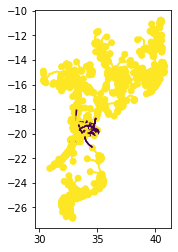

In [51]:
df_res_tcfl[(df_res_tcfl.ci_type=='power_line')].plot('func_tot')

In [57]:
df_res_tcfl[(df_res_tcfl.ci_type=='power_line') & (df_res_tcfl.func_internal==0)]['length'].sum()

2053815.1506564969

In [58]:
df_res_tcfl[(df_res_tcfl.ci_type=='power_line') & (df_res_tcfl.func_internal==0)]['length'].sum()/1000

2053.815150656497

In [71]:
df_res_tcfl[(df_res_tcfl.ci_type=='power_line') & ((df_res_tcfl.imp_dir/df_res_tcfl['length'])>0.01)]['length'].sum()/1000

1254.209676513732

In [60]:
df_res_tcfl[(df_res_tcfl.ci_type=='road') & (df_res_tcfl.func_internal==0)]['length'].sum()/1000

35276.22638514166

In [72]:
df_res_tcfl[(df_res_tcfl.ci_type=='road') & ((df_res_tcfl.imp_dir*0.5/df_res_tcfl['length'])>0.5)]['length'].sum()/1000

16906.947303698333

In [59]:
len(df_res_tcfl[(df_res_tcfl.ci_type=='education') & ((df_res_tcfl.imp_dir)])

292

In [17]:
print(df_res_tc[df_res_tc.ci_type=='power_line'].func_tot.sum())
print(len(df_res_tc[df_res_tc.ci_type=='power_line']))


9032
9297


<AxesSubplot: >

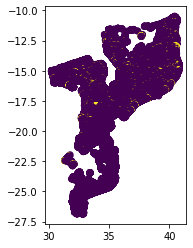

In [38]:
df_res_tc[(df_res_tc['ci_type']=='people')].plot('actual_supply_power_line_people')

In [37]:
df_res_tc[(df_res_tc['ci_type']=='people')].counts.sum()*0.37

10906495.952470837

In [106]:
if haz_type=='TCFL':
    # combine direct flood & wind impacts from previous runs
    df_res_tc = gpd.read_feather(path_save+f'cascade_results_2019063S18038')
    df_res_fl = gpd.read_feather(path_save+f'cascade_results_Flood_Idai')
    df_res = combine_result_dfs(df_res_tc, df_res_fl)

In [25]:
df_res_tc.groupby('ci_type').func_tot.mean()

ci_type
celltower      0.526399
education      0.395528
health         0.708747
people         1.000000
power_line     0.971496
power_plant    1.000000
road           0.987089
Name: func_tot, dtype: float64

In [109]:
df_res_tc.groupby('ci_type').func_internal.mean()

ci_type
celltower      0.972419
education      0.936006
health         0.981966
people         1.000000
power_line     0.976874
power_plant    1.000000
road           0.987089
Name: func_internal, dtype: float64

In [65]:
df_res_fl.groupby('ci_type').func_internal.mean()

ci_type
celltower      0.994484
education      0.979954
health         0.991885
people         1.000000
power_line     0.996235
power_plant    1.000000
road           0.987063
Name: func_internal, dtype: float64